In [1]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# pltで画像見る用
def BGR2RGB(img):
    img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0].copy()
    return img

# Q.31 アフィン変換(スキュー)

True

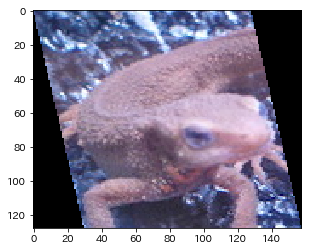

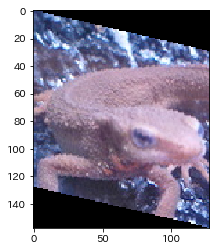

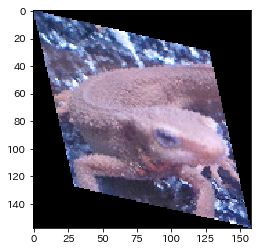

In [10]:
def affine(img, a=1, b=0, c=0, d=1, tx=0, ty=0):
    H, W, C = img.shape
    
    aH = int(c*W+d*H)
    aW = int(a*W+b*H)
    
    y = np.arange(aH).repeat(aW).reshape(aH, -1)
    x = np.tile(np.arange(aW), (aH, 1))
    
    ix = (d*x - b*y) / (a*d - b*c) - tx
    iy = (-c*x + a*y) / (a*d - b*c) - ty
    
    ix = np.round(ix).astype(np.int)
    iy = np.round(iy).astype(np.int)
    
    out = np.zeros((aH, aW, C), dtype=np.float32)
    
    for j in range(aH):
        for i in range(aW):
            if (0 <= iy[j, i] and iy[j ,i] < W) and (0 <= ix[j, i] and ix[j, i] < H):
                out[j, i] = img[iy[j, i], ix[j, i]]
                
    out = out.astype(np.uint8)
    
    return out

img = cv2.imread("imori.jpg").astype(np.float)
h, w, c = img.shape

out1 = affine(img, a=1, b=30/h, c=0, d=1)
plt.figure()
plt.imshow(BGR2RGB(out1))

out2 = affine(img, a=1, b=0, c=30/w, d=1)
plt.figure()
plt.imshow(BGR2RGB(out2))

out3 = affine(img, a=1, b=30/h, c=30/w, d=1)
plt.figure()
plt.imshow(BGR2RGB(out3))

cv2.imwrite("answers/answer31_1.jpg", out1)
cv2.imwrite("answers/answer31_2.jpg", out2)
cv2.imwrite("answers/answer31_3.jpg", out3)

# Q.32 フーリエ変換

True

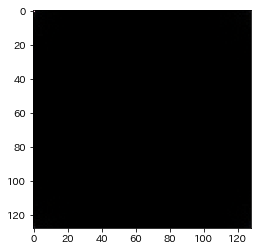

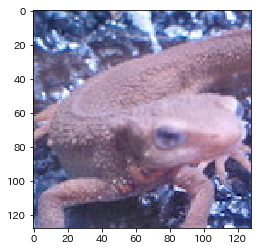

In [15]:
def DFT(img):
    H, W, C = img.shape
    
    out = np.zeros((H, W, C), dtype=np.complex)
    
    y = np.arange(H).repeat(W).reshape(H, -1)
    x = np.tile(np.arange(W), (H, 1))
    
    for c in range(C):
        for l in range(H):
            for k in range(W):
                out[l, k, c] = np.sum(img[..., c] * np.exp(-2j * np.pi * (x * k / W + y * l / H))) / np.sqrt(W * H)
                
    return out

def IDFT(out):
    H, W, C = out.shape
    
    img = np.zeros((H, W, C), dtype=np.float)
    
    y = np.arange(H).repeat(W).reshape(H, -1)
    x = np.tile(np.arange(W), (H, 1))
    
    for c in range(C):
        for l in range(H):
            for k in range(W):
                img[l, k, c] = np.abs(np.sum(out[..., c] * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / np.sqrt(W * H)
        
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    
    return img

img = cv2.imread("imori.jpg").astype(np.float32)
out = DFT(img)

ps = (np.abs(out) / np.abs(out).max() * 255).astype(np.uint8)
plt.figure()
plt.imshow(ps)

img = IDFT(out)
plt.figure()
plt.imshow(BGR2RGB(img))

cv2.imwrite("answers/answer32_ps.jpg", ps)
cv2.imwrite("answers/answer32.jpg", img)

# Q.33 フーリエ変換 ローパスフィルタ

True

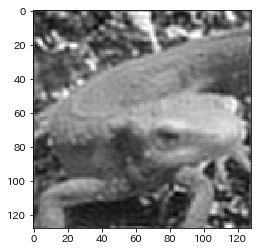

In [20]:
def DFT_gray(img):
    H, W = img.shape
    
    out = np.zeros((H, W), dtype=np.complex)
    
    y = np.arange(H).repeat(W).reshape(H, -1)
    x = np.tile(np.arange(W), (H, 1))
    
    for l in range(H):
        for k in range(W):
            out[l, k] = np.sum(img * np.exp(-2j * np.pi * (x * k / W + y * l / H))) / np.sqrt(W * H)
                
    return out

def IDFT_gray(out):
    H, W = out.shape
    
    img = np.zeros((H, W), dtype=np.float)
    
    y = np.arange(H).repeat(W).reshape(H, -1)
    x = np.tile(np.arange(W), (H, 1))
    
    for l in range(H):
        for k in range(W):
            img[l, k] = np.abs(np.sum(out * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / np.sqrt(W * H)
        
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    
    return img

def LPF(out, ratio=0.5):
    H, W = out.shape
    
    _out = np.zeros_like(out)
    _out[:H//2, :W//2] = out[H//2:, W//2:]
    _out[:H//2, W//2:] = out[H//2:, :W//2]
    _out[H//2:, :W//2] = out[:H//2, W//2:]
    _out[H//2:, W//2:] = out[:H//2, :W//2]
    
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    x = x - W//2
    y = y - H//2
    r = np.sqrt(x**2 + y**2)
    fil = np.ones((H, W), dtype=np.float32)
    fil[r > (W//2 * ratio)] = 0
    
    _out *= fil
    
    out[:H//2, :W//2] = _out[H//2:, W//2:]
    out[:H//2, W//2:] = _out[H//2:, :W//2]
    out[H//2:, :W//2] = _out[:H//2, W//2:]
    out[H//2:, W//2:] = _out[:H//2, :W//2]
    
    return _out

img = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DFT_gray(img)
out = LPF(out)
img = IDFT_gray(out)

plt.figure()
plt.imshow(img, cmap="gray")

cv2.imwrite("answers/answer33.jpg", img)

# Q.34 ハイパスフィルタ

True

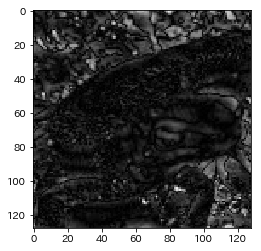

In [21]:
def HPF(out, ratio=0.1):
    H, W = out.shape
    
    _out = np.zeros_like(out)
    _out[:H//2, :W//2] = out[H//2:, W//2:]
    _out[:H//2, W//2:] = out[H//2:, :W//2]
    _out[H//2:, :W//2] = out[:H//2, W//2:]
    _out[H//2:, W//2:] = out[:H//2, :W//2]
    
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    x = x - W//2
    y = y - H//2
    r = np.sqrt(x**2 + y**2)
    fil = np.zeros((H, W), dtype=np.float32)
    fil[r > (W//2 * ratio)] = 1
    
    _out *= fil
    
    out[:H//2, :W//2] = _out[H//2:, W//2:]
    out[:H//2, W//2:] = _out[H//2:, :W//2]
    out[H//2:, :W//2] = _out[:H//2, W//2:]
    out[H//2:, W//2:] = _out[:H//2, :W//2]
    
    return _out

img = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DFT_gray(img)
out = HPF(out)
img = IDFT_gray(out)

plt.figure()
plt.imshow(img, cmap="gray")

cv2.imwrite("answers/answer34.jpg", img)

# Q.35 バンドパスフィルタ

True

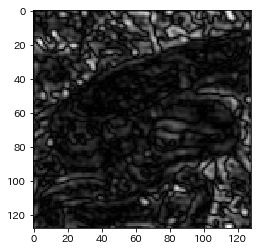

In [24]:
def BPF(out, ratio1=0.1, ratio2=0.5):
    H, W = out.shape
    
    _out = np.zeros_like(out)
    _out[:H//2, :W//2] = out[H//2:, W//2:]
    _out[:H//2, W//2:] = out[H//2:, :W//2]
    _out[H//2:, :W//2] = out[:H//2, W//2:]
    _out[H//2:, W//2:] = out[:H//2, :W//2]
    
    x = np.tile(np.arange(W), (H, 1))
    y = np.arange(H).repeat(W).reshape(H, -1)
    
    x = x - W//2
    y = y - H//2
    r = np.sqrt(x**2 + y**2)
    fil = np.zeros((H, W), dtype=np.float32)
    fil[(r > (W//2 * ratio1)) & (r < (W//2 * ratio2))] = 1
    
    _out *= fil
    
    out[:H//2, :W//2] = _out[H//2:, W//2:]
    out[:H//2, W//2:] = _out[H//2:, :W//2]
    out[H//2:, :W//2] = _out[:H//2, W//2:]
    out[H//2:, W//2:] = _out[:H//2, :W//2]
    
    return _out

img = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DFT_gray(img)
out = BPF(out)
img = IDFT_gray(out)

plt.figure()
plt.imshow(img, cmap="gray")

cv2.imwrite("answers/answer35.jpg", img)

# Q.36 JPEG圧縮 (Step.1)離散コサイン変換

True

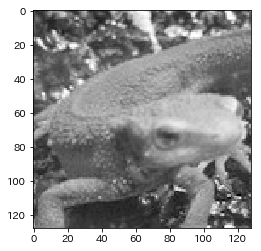

In [96]:
def C(u):
    if u == 0:
        return 1/np.sqrt(2)
    else:
        return 1

def DCT(img, T=8):
    H, W = img.shape
    
    y = np.arange(T).repeat(T).reshape(T, -1)
    x = np.tile(np.arange(T), (T, 1))
    
    out = np.zeros_like(img)
    
    for j in range(H//T):
        for i in range(W//T):
            for u in range(T):
                for v in range(T):
                    out[j*T+v, i*T+u] = 2 / T * C(u) * C(v) * np.sum(img[j*T+y, i*T+x] * np.cos((2*x+1)*u*np.pi/2/T) * np.cos((2*y+1)*v*np.pi/2/T))
    
    return out

def IDCT(out, T=8, K=8):
    def C(u):
        if u == 0:
            return 1/np.sqrt(2)
        else:
            return 1

    H, W = out.shape
    
    v = np.arange(K).repeat(K).reshape(K, -1)
    u = np.tile(np.arange(K), (K, 1))
    
    img = np.zeros_like(out)
    
    C = np.frompyfunc(C, 1, 1)
    
    for j in range(H//T):
        for i in range(W//T):
            for y in range(T):
                for x in range(T):
                    img[j*T+y, i*T+x] = 2 / T * np.sum(C(v) * C(u) * out[j*T+v, i*T+u] * np.cos((2*x+1)*u*np.pi/2/T) * np.cos((2*y+1)*v*np.pi/2/T))
    
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    
    return img

img = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DCT(img)
img = IDCT(out)

plt.figure()
plt.imshow(img, cmap="gray")

cv2.imwrite("answers/answer36.jpg", img)

# Q.37 PSNR

MSE: 116.36871
PSNR: 27.47244128262811
bitrate: 2.0


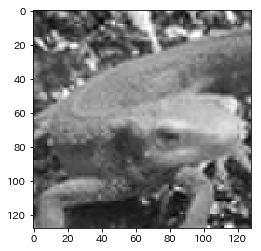

In [97]:
def MSE(img1, img2):
    H, W = img1.shape
    mse = np.sum((img1 - img2) ** 2 / (H * W))
    return mse

def PSNR(mse, vmax=255):
    return 10 * np.log10(vmax * vmax / mse)

def BITRATE(K=8):
    return K * K / 8

img1 = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DCT(img1, T=8)
img2 = IDCT(out, K=4)

mse = MSE(img1, img2)
psnr = PSNR(mse)
bitrate  = BITRATE(K=4)

print("MSE:", mse)
print("PSNR:", psnr)
print("bitrate:", bitrate)

plt.figure()
plt.imshow(img2, cmap="gray")

# Q.38 JPEG圧縮 (Step.2)DCT+量子化

True

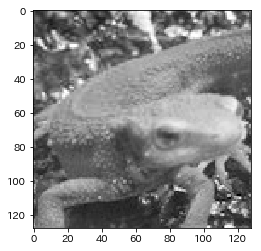

In [98]:
def quantization(out, T=8):
    H, W = out.shape
    
    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                (12, 12, 14, 19, 26, 58, 60, 55),
                (14, 13, 16, 24, 40, 57, 69, 56),
                (14, 17, 22, 29, 51, 87, 80, 62),
                (18, 22, 37, 56, 68, 109, 103, 77),
                (24, 35, 55, 64, 81, 104, 113, 92),
                (49, 64, 78, 87, 103, 121, 120, 101),
                (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    
    for j in range(T):
        for i in range(T):
            out[j*T:j*T+T, i*T:i*T+T] = np.round(out[j*T:j*T+T, i*T:i*T+T] / Q) *Q
    
    return out

img = cv2.imread("imori_gray.jpg", 0).astype(np.float32)
out = DCT(img)
out = quantization(out)
img = IDCT(out)

plt.figure()
plt.imshow(img, cmap="gray")

cv2.imwrite("answers/answer38.jpg", img)

# Q.39 JPEG圧縮 (Step.3)YCbCr表色系

True

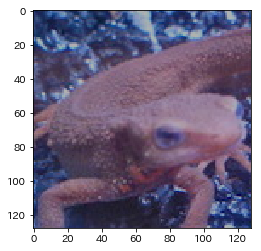

In [101]:
def BGR2YCbCr(img):
    H, W, _ = img.shape
    
    ycbcr = np.zeros((H, W, 3), dtype=np.float32)
    
    ycbcr[..., 0] = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
    ycbcr[..., 1] = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
    ycbcr[..., 2] = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.
    
    return ycbcr

def YCbCr2BGR(ycbcr):
    H, W, _ = ycbcr.shape
    
    out = np.zeros([H, W, 3], dtype=np.float32)
    out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.4020
    out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
    out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    
    return out

img = cv2.imread("imori.jpg").astype(np.float32)
ycbcr = BGR2YCbCr(img)
ycbcr[:, :, 0] *= 0.7
out = YCbCr2BGR(ycbcr)

plt.figure()
plt.imshow(BGR2RGB(out))

cv2.imwrite("answers/answer39.jpg", img)

True

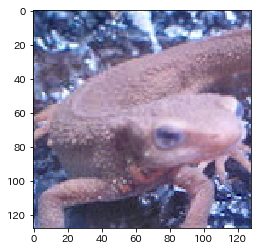

In [102]:
def DCT(img, T=8):
    H, W, channel= img.shape
    
    y = np.arange(T).repeat(T).reshape(T, -1)
    x = np.tile(np.arange(T), (T, 1))
    
    out = np.zeros_like(img)
    
    for c in range(channel):
        for j in range(H//T):
            for i in range(W//T):
                for u in range(T):
                    for v in range(T):
                        out[j*T+v, i*T+u, c] = 2 / T * C(u) * C(v) * np.sum(img[j*T+y, i*T+x, c] * np.cos((2*x+1)*u*np.pi/2/T) * np.cos((2*y+1)*v*np.pi/2/T))
    
    return out

def IDCT(out, T=8, K=8):
    def C(u):
        if u == 0:
            return 1/np.sqrt(2)
        else:
            return 1

    H, W, channel = out.shape
    
    v = np.arange(K).repeat(K).reshape(K, -1)
    u = np.tile(np.arange(K), (K, 1))
    
    img = np.zeros_like(out)
    
    C = np.frompyfunc(C, 1, 1)
    
    for c in range(channel):
        for j in range(H//K):
            for i in range(W//K):
                for y in range(K):
                    for x in range(K):
                        img[j*K+y, i*K+x, c] = 2 / T * np.sum(C(v) * C(u) * out[j*K+v, i*K+u, c] * np.cos((2*x+1)*u*np.pi/2/T) * np.cos((2*y+1)*v*np.pi/2/T))
    
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    
    return img

def special_quantization(out, T=8):
    H, W, _ = out.shape
    
    Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    
    Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)
    
    for j in range(T):
        for i in range(T):
            out[j*T:j*T+T, i*T:i*T+T, 0] = np.round(out[j*T:j*T+T, i*T:i*T+T, 0] / Q1) *Q1
            out[j*T:j*T+T, i*T:i*T+T, 1] = np.round(out[j*T:j*T+T, i*T:i*T+T, 1] / Q2) *Q2
            out[j*T:j*T+T, i*T:i*T+T, 2] = np.round(out[j*T:j*T+T, i*T:i*T+T, 2] / Q2) *Q2
    
    return out

img = cv2.imread("imori.jpg").astype(np.float32)
ycbcr = BGR2YCbCr(img)
out = DCT(ycbcr)
out = special_quantization(out)
ycbcr = IDCT(out)
img = YCbCr2BGR(ycbcr)

plt.figure()
plt.imshow(BGR2RGB(img))

cv2.imwrite("answers/answer40.jpg", img)